In [ ]:
# Required Libraries
import pandas as pd
import re
import string
import nltk
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_predict, train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.utils import class_weight
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Bidirectional, Embedding, LSTM, Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, concatenate
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## **Dataset Preprocessing**

In [ ]:
# Load dataset
df = pd.read_csv("Suicidal code mixed  Dataset.csv", encoding='latin1')

In [ ]:
# Basic info
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7058 entries, 0 to 7057
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      7058 non-null   object
 1   Suicidal  7058 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 110.4+ KB
None
                                                text  Suicidal
0  main khud se itnaa nphrt krtaa huun ki main ca...         1
1          Reddit main apne pr ek ke saath jaag gyaa         1
2             main caahtaa huun fucking kill myself          1
3  main apne sbhii ko kyon main jaa rhaa huun mys...         1
4           kyaa bkvaas im doing wrong with my life          1


In [ ]:
# Drop rows with missing 'text'
df = df.dropna()

In [ ]:
df.head()

,text,Suicidal
0,main khud se itnaa nphrt krtaa huun ki main ca...,1
1,Reddit main apne pr ek ke saath jaag gyaa,1
2,main caahtaa huun fucking kill myself,1
3,main apne sbhii ko kyon main jaa rhaa huun mys...,1
4,kyaa bkvaas im doing wrong with my life,1


In [ ]:
df['Suicidal'].value_counts()

,count
Suicidal,
0,3652
1,3406


In [ ]:
# Remove duplicate rows
df.drop_duplicates(inplace=True)

# Reset index after removal
df.reset_index(drop=True, inplace=True)

In [ ]:
#Lowercase
df['text'][1].lower()

'reddit main apne pr ek ke saath jaag gyaa'

In [ ]:
df['text']=df['text'].str.lower()

In [ ]:
#Removing punctuations
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
exclude=string.punctuation

In [ ]:
def remove_punct(text):
  return text.translate(str.maketrans('','',exclude))

In [ ]:
df['text'] = df['text'].apply(remove_punct)

In [ ]:
# Remove digits
def remove_digits(text):
    return text.translate(str.maketrans('', '', '0123456789'))

In [ ]:
df['text'] = df['text'].apply(remove_digits)

In [ ]:
# Remove extra spaces
def remove_extra_spaces(text):
    return re.sub(r'\s+', ' ', text).strip()

In [ ]:
df['text'] = df['text'].apply(remove_extra_spaces)

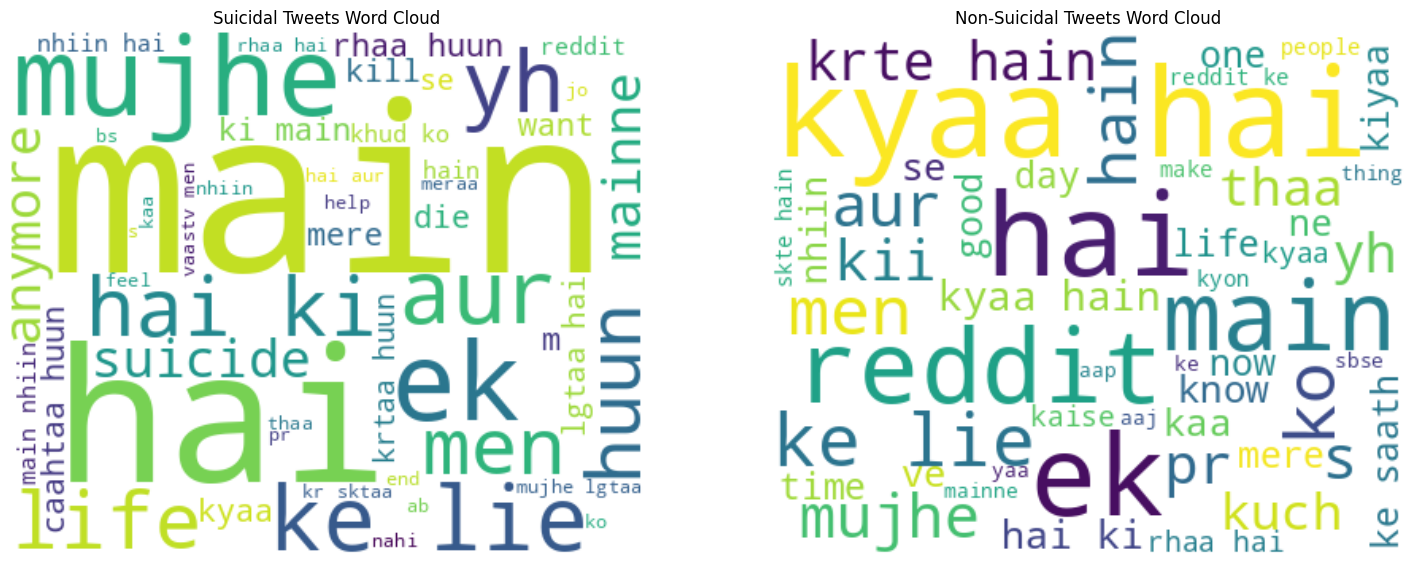

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Separate texts based on label
suicidal_text = " ".join(df[df['Suicidal'] == 1]['text'].tolist())
nonsuicidal_text = " ".join(df[df['Suicidal'] == 0]['text'].tolist())

# Generate word clouds
wc_suicidal = WordCloud(width=400, height=330, max_words=50, background_color='white').generate(suicidal_text)
wc_nonsuicidal = WordCloud(width=400, height=330, max_words=50, background_color='white').generate(nonsuicidal_text)

# Plot side by side
plt.figure(figsize=(18, 8))

plt.subplot(1, 2, 1)
plt.title("Suicidal Tweets Word Cloud")
plt.imshow(wc_suicidal, interpolation='bilinear')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Non-Suicidal Tweets Word Cloud")
plt.imshow(wc_nonsuicidal, interpolation='bilinear')
plt.axis('off')

plt.show()



In [ ]:
from nltk.tokenize import WordPunctTokenizer

tokenizer = WordPunctTokenizer()

df['token'] = df['text'].apply(lambda x: tokenizer.tokenize(x))

In [ ]:
print(df['token'])

0       [main, khud, se, itnaa, nphrt, krtaa, huun, ki...
1       [reddit, main, apne, pr, ek, ke, saath, jaag, ...
2            [main, caahtaa, huun, fucking, kill, myself]
3       [main, apne, sbhii, ko, kyon, main, jaa, rhaa,...
4        [kyaa, bkvaas, im, doing, wrong, with, my, life]
                              ...                        
6970    [jo, log, sab, ke, liye, hote, hain, unke, liy...
6971    [kabhi, kabhi, khud, se, hi, baat, karna, sabs...
6972    [jo, dard, nahi, dikhate, wahi, sabse, zyada, ...
6973    [akele, rehna, koi, punishment, nahi, hai, sha...
6974    [kabhi, kisi, se, kuch, kehne, ka, mann, karta...
Name: token, Length: 6975, dtype: object


In [ ]:
normalization_dict = {
    'krtaa': 'krta',
    'krti': 'karti',
    'huun': 'hun',
    'hu': 'hun',
    'caahtaa': 'chahta',
    'chahta': 'chahta',
    'chahtaa': 'chahta',
    'kyaa': 'kya',
    'kyaaa': 'kya',
    'kyun': 'kyu',
    'sbhi': 'sabhi',
    'sbhii': 'sabhi',
    'sbka': 'sabka',
    'main': 'mai',
    'me': 'mai',
    'mujhe': 'mujhko',
    'muje': 'mujhko',
    'mujhko': 'mujhko',
    'kro': 'karo',
    'kra': 'kara',
    'kri': 'kari',
    'kre': 'kare',
    'kr': 'kar',
    'rha': 'raha',
    'rhi': 'rahi',
    'rhe': 'rahe',
    'aj': 'aaj',
    'kl': 'kal',
    'jb': 'jab',
    'nhi': 'nahi',
    'nai': 'nahi',
    'ni': 'nahi',
    'haa': 'haan',
    'han': 'haan',
    'hn': 'haan',
    'bht': 'bahut',
    'bahot': 'bahut',
    'bahoot': 'bahut',
    'bahut': 'bahut',
    'achaa': 'acha',
    'accha': 'acha',
    'shi': 'sahi',
    'gyaa': 'gaya',
    'gya': 'gaya',
    'aa': 'aaya',
    'mrna': 'marna',
    'marnaaa': 'marna',
    'zindgi': 'zindagi',
    'lyf': 'life',
    'lif': 'life',
    'lifee': 'life',
    'yaar': 'yaar',
    'yr': 'yaar',
    'frnd': 'friend',
    'frnds': 'friends',
    'dost': 'dost',
    'pyar': 'pyaar',
    'pyr': 'pyaar',
    'lovee': 'love',
    'luv': 'love',
    'lvu': 'love',
    'itnaa': 'itna',

}
def normalize_tokens(tokens):
    return [normalization_dict.get(tok, tok) for tok in tokens]

df['normalized_tokens'] = df['token'].apply(normalize_tokens)

In [ ]:
df['normalized_tokens']

,normalized_tokens
0,"[mai, khud, se, itna, nphrt, krta, hun, ki, ma..."
1,"[reddit, mai, apne, pr, ek, ke, saath, jaag, g..."
2,"[mai, chahta, hun, fucking, kill, myself]"
3,"[mai, apne, sabhi, ko, kyon, mai, jaa, rhaa, h..."
4,"[kya, bkvaas, im, doing, wrong, with, my, life]"
...,...
6970,"[jo, log, sab, ke, liye, hote, hain, unke, liy..."
6971,"[kabhi, kabhi, khud, se, hi, baat, karna, sabs..."
6972,"[jo, dard, nahi, dikhate, wahi, sabse, zyada, ..."
6973,"[akele, rehna, koi, punishment, nahi, hai, sha..."


In [ ]:
df

,text,Suicidal,token,normalized_tokens
0,main khud se itnaa nphrt krtaa huun ki main ca...,1,"[main, khud, se, itnaa, nphrt, krtaa, huun, ki...","[mai, khud, se, itna, nphrt, krta, hun, ki, ma..."
1,reddit main apne pr ek ke saath jaag gyaa,1,"[reddit, main, apne, pr, ek, ke, saath, jaag, ...","[reddit, mai, apne, pr, ek, ke, saath, jaag, g..."
2,main caahtaa huun fucking kill myself,1,"[main, caahtaa, huun, fucking, kill, myself]","[mai, chahta, hun, fucking, kill, myself]"
3,main apne sbhii ko kyon main jaa rhaa huun mys...,1,"[main, apne, sbhii, ko, kyon, main, jaa, rhaa,...","[mai, apne, sabhi, ko, kyon, mai, jaa, rhaa, h..."
4,kyaa bkvaas im doing wrong with my life,1,"[kyaa, bkvaas, im, doing, wrong, with, my, life]","[kya, bkvaas, im, doing, wrong, with, my, life]"
...,...,...,...,...
6970,jo log sab ke liye hote hain unke liye kaun ho...,0,"[jo, log, sab, ke, liye, hote, hain, unke, liy...","[jo, log, sab, ke, liye, hote, hain, unke, liy..."
6971,kabhi kabhi khud se hi baat karna sabse real f...,0,"[kabhi, kabhi, khud, se, hi, baat, karna, sabs...","[kabhi, kabhi, khud, se, hi, baat, karna, sabs..."
6972,jo dard nahi dikhate wahi sabse zyada mehsoos ...,0,"[jo, dard, nahi, dikhate, wahi, sabse, zyada, ...","[jo, dard, nahi, dikhate, wahi, sabse, zyada, ..."
6973,akele rehna koi punishment nahi hai shayad com...,0,"[akele, rehna, koi, punishment, nahi, hai, sha...","[akele, rehna, koi, punishment, nahi, hai, sha..."


In [ ]:
print(type(df.loc[0, 'normalized_tokens']))

<class 'list'>


In [ ]:
print(df.loc[0, 'normalized_tokens'])

['mai', 'khud', 'se', 'itna', 'nphrt', 'krta', 'hun', 'ki', 'mai', 'chahta', 'hun', 'to', 'kill', 'myself', 'how', 'are', 'yaeur', 'tm', 'all']


In [ ]:
df['clean_text'] = df['normalized_tokens'].apply(lambda tokens: ' '.join(tokens))

In [ ]:
df

,text,Suicidal,token,normalized_tokens,clean_text
0,main khud se itnaa nphrt krtaa huun ki main ca...,1,"[main, khud, se, itnaa, nphrt, krtaa, huun, ki...","[mai, khud, se, itna, nphrt, krta, hun, ki, ma...",mai khud se itna nphrt krta hun ki mai chahta ...
1,reddit main apne pr ek ke saath jaag gyaa,1,"[reddit, main, apne, pr, ek, ke, saath, jaag, ...","[reddit, mai, apne, pr, ek, ke, saath, jaag, g...",reddit mai apne pr ek ke saath jaag gaya
2,main caahtaa huun fucking kill myself,1,"[main, caahtaa, huun, fucking, kill, myself]","[mai, chahta, hun, fucking, kill, myself]",mai chahta hun fucking kill myself
3,main apne sbhii ko kyon main jaa rhaa huun mys...,1,"[main, apne, sbhii, ko, kyon, main, jaa, rhaa,...","[mai, apne, sabhi, ko, kyon, mai, jaa, rhaa, h...",mai apne sabhi ko kyon mai jaa rhaa hun myself...
4,kyaa bkvaas im doing wrong with my life,1,"[kyaa, bkvaas, im, doing, wrong, with, my, life]","[kya, bkvaas, im, doing, wrong, with, my, life]",kya bkvaas im doing wrong with my life
...,...,...,...,...,...
6970,jo log sab ke liye hote hain unke liye kaun ho...,0,"[jo, log, sab, ke, liye, hote, hain, unke, liy...","[jo, log, sab, ke, liye, hote, hain, unke, liy...",jo log sab ke liye hote hain unke liye kaun ho...
6971,kabhi kabhi khud se hi baat karna sabse real f...,0,"[kabhi, kabhi, khud, se, hi, baat, karna, sabs...","[kabhi, kabhi, khud, se, hi, baat, karna, sabs...",kabhi kabhi khud se hi baat karna sabse real f...
6972,jo dard nahi dikhate wahi sabse zyada mehsoos ...,0,"[jo, dard, nahi, dikhate, wahi, sabse, zyada, ...","[jo, dard, nahi, dikhate, wahi, sabse, zyada, ...",jo dard nahi dikhate wahi sabse zyada mehsoos ...
6973,akele rehna koi punishment nahi hai shayad com...,0,"[akele, rehna, koi, punishment, nahi, hai, sha...","[akele, rehna, koi, punishment, nahi, hai, sha...",akele rehna koi punishment nahi hai shayad com...


In [ ]:
df['clean_text']

,clean_text
0,mai khud se itna nphrt krta hun ki mai chahta ...
1,reddit mai apne pr ek ke saath jaag gaya
2,mai chahta hun fucking kill myself
3,mai apne sabhi ko kyon mai jaa rhaa hun myself...
4,kya bkvaas im doing wrong with my life
...,...
6970,jo log sab ke liye hote hain unke liye kaun ho...
6971,kabhi kabhi khud se hi baat karna sabse real f...
6972,jo dard nahi dikhate wahi sabse zyada mehsoos ...
6973,akele rehna koi punishment nahi hai shayad com...


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize vectorizer (max_features limit optional hai)
vectorizer = TfidfVectorizer(max_features=5000)

# Fit on data and transform text to vectors
X_tfidf = vectorizer.fit_transform(df['clean_text'])
print(X_tfidf.shape)


(6975, 4122)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import pandas as pd

# Evaluation helper function
def evaluate_model(name, y_true, y_pred, results_list):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"\n✅ {name} Results")
    print(f"Accuracy: {acc:.4f}")
    print("📄 Classification Report:\n", classification_report(y_true, y_pred))

    results_list.append({
        "Model": name,
        "Accuracy": acc,
        "F1": f1,
        "Precision": prec,
        "Recall": rec
    })

# Convert TF-IDF sparse matrix to dense (only if needed)
X = X_tfidf.toarray()
y = df['Suicidal']     # Assuming 'Suicidal' is your target column

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Decision Tree": DecisionTreeClassifier(max_depth=50, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Gaussian Naive Bayes": GaussianNB(),
}

results = []

# Train and evaluate models
for name, model in models.items():
    print(f"\n🔧 Training: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    evaluate_model(name, y_test, y_pred, results)

# Create DataFrame from results
df_results = pd.DataFrame(results)
print("\n📊 Model Comparison:\n")
print(df_results.sort_values(by='F1', ascending=False).reset_index(drop=True))



🔧 Training: Random Forest

✅ Random Forest Results
Accuracy: 0.8746
📄 Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.88      0.88       710
           1       0.88      0.87      0.87       685

    accuracy                           0.87      1395
   macro avg       0.87      0.87      0.87      1395
weighted avg       0.87      0.87      0.87      1395


🔧 Training: Decision Tree

✅ Decision Tree Results
Accuracy: 0.7957
📄 Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.80      0.80       710
           1       0.79      0.79      0.79       685

    accuracy                           0.80      1395
   macro avg       0.80      0.80      0.80      1395
weighted avg       0.80      0.80      0.80      1395


🔧 Training: Logistic Regression

✅ Logistic Regression Results
Accuracy: 0.8875
📄 Classification Report:
               precision    recall  f1-score   sup

In [ ]:
from sklearn.svm import SVC

# Define and train SVM model
svm_model = SVC(kernel='rbf', probability=True)
svm_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_svm = svm_model.predict(X_test)

evaluate_model("SVM (RBF Kernel)", y_test, y_pred_svm, results)



✅ SVM (RBF Kernel) Results
Accuracy: 0.9039
📄 Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.90      0.91       710
           1       0.90      0.91      0.90       685

    accuracy                           0.90      1395
   macro avg       0.90      0.90      0.90      1395
weighted avg       0.90      0.90      0.90      1395



In [ ]:
# Sample input text
sample_text = [" main marna chahata hu"]

# Vectorize and convert to dense
sample_vector = vectorizer.transform(sample_text)
sample_vector_dense = sample_vector.toarray()

# Use trained SVM model for prediction
svm_model = models["SVM (RBF Kernel)"]
prediction = svm_model.predict(sample_vector_dense)

print("Prediction:", "Suicidal" if prediction[0] == 1 else "Non-Suicidal")


Prediction: Suicidal


In [ ]:
#CNN model
# 🔧 Hyperparameters
max_words = 10000
max_len = 100
embedding_dim = 50
batch_size = 32
epochs = 15

# 📄 Prepare data
texts = df['clean_text'].values
labels = df['Suicidal'].values

texts_train, texts_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

# ✨ Tokenization and Padding
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts_train)

X_train = tokenizer.texts_to_sequences(texts_train)
X_test = tokenizer.texts_to_sequences(texts_test)

X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

# 🔨 Define CNN model
cnn_model = Sequential()
cnn_model.add(Embedding(max_words, embedding_dim, input_length=max_len))
cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(10, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(1, activation='sigmoid'))

# 🧠 Compile
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 🏋️‍♀️ Train
cnn_model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test)
)

# 🎯 Predict
y_pred_prob = cnn_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# 📊 Evaluate
evaluate_model("CNN Model", y_test, y_pred, results)


Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


175/175 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.6272 - loss: 0.6443 - val_accuracy: 0.8480 - val_loss: 0.3768
Epoch 2/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8662 - loss: 0.3762 - val_accuracy: 0.8910 - val_loss: 0.2826
Epoch 3/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9333 - loss: 0.2466 - val_accuracy: 0.8946 - val_loss: 0.2830
Epoch 4/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9552 - loss: 0.1476 - val_accuracy: 0.8796 - val_loss: 0.3230
Epoch 5/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9707 - loss: 0.1153 - val_accuracy: 0.8738 - val_loss: 0.3472
Epoch 6/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9756 - loss: 0.0857 - val_accuracy: 0.8760 - val_loss: 0.4254
Epoch 7/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9818 - loss: 0.0742 - val_accuracy: 0.8796 - val_loss: 0.4666
Epoch 8/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9867 - loss: 0.0562 - val_accuracy: 0.8824 - val

In [ ]:
#RNN Model
max_words = 10000      # Vocabulary size
max_len = 100          # Max sequence length
embedding_dim = 50     # Embedding vector size
batch_size = 32
epochs = 15

texts = df['clean_text'].values
labels = df['Suicidal'].values

texts_train, texts_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts_train)

X_train = tokenizer.texts_to_sequences(texts_train)
X_test = tokenizer.texts_to_sequences(texts_test)

X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

# RNN Model
rnnmodel = Sequential()
rnnmodel.add(Embedding(max_words, embedding_dim, input_length=max_len))
rnnmodel.add(SimpleRNN(64, return_sequences=False))
rnnmodel.add(Dropout(0.5))
rnnmodel.add(Dense(1, activation='sigmoid'))

rnnmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = rnnmodel.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test)
)
y_pred_prob = rnnmodel.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

evaluate_model("RNN Model", y_test, y_pred, results)


Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


175/175 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.6292 - loss: 0.6188 - val_accuracy: 0.8358 - val_loss: 0.3758
Epoch 2/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8867 - loss: 0.2893 - val_accuracy: 0.8609 - val_loss: 0.3086
Epoch 3/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9435 - loss: 0.1616 - val_accuracy: 0.8667 - val_loss: 0.3136
Epoch 4/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9576 - loss: 0.1250 - val_accuracy: 0.8839 - val_loss: 0.3014
Epoch 5/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9835 - loss: 0.0618 - val_accuracy: 0.8817 - val_loss: 0.3231
Epoch 6/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9863 - loss: 0.0479 - val_accuracy: 0.8201 - val_loss: 0.4504
Epoch 7/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9045 - loss: 0.2712 - val_accuracy: 0.8767 - val_loss: 0.3737
Epoch 8/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9750 - loss: 0.0707 - val_accuracy: 0.8695 

In [ ]:
#LSTM model

max_words = 10000
max_len = 100
embedding_dim = 50
batch_size = 32
epochs = 15

texts = df['clean_text'].values
labels = df['Suicidal'].values

texts_train, texts_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts_train)

X_train = tokenizer.texts_to_sequences(texts_train)
X_test = tokenizer.texts_to_sequences(texts_test)

X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

# LSTM Model
ltsmmodel = Sequential()
ltsmmodel.add(Embedding(max_words, embedding_dim, input_length=max_len))
ltsmmodel.add(LSTM(64))
ltsmmodel.add(Dropout(0.5))
ltsmmodel.add(Dense(1, activation='sigmoid'))

ltsmmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

ltsmmodel.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test)
)

y_pred_lstm = (ltsmmodel.predict(X_test) > 0.5).astype(int).flatten()
evaluate_model("LSTM Model", y_test, y_pred_lstm, results)


Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6860 - loss: 0.5968 - val_accuracy: 0.8609 - val_loss: 0.3145
Epoch 2/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8999 - loss: 0.2601 - val_accuracy: 0.8703 - val_loss: 0.2880
Epoch 3/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9409 - loss: 0.1644 - val_accuracy: 0.8810 - val_loss: 0.2783
Epoch 4/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9581 - loss: 0.1198 - val_accuracy: 0.8767 - val_loss: 0.3266
Epoch 5/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9709 - loss: 0.0988 - val_accuracy: 0.8860 - val_loss: 0.3403
Epoch 6/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9774 - loss: 0.0844 - val_accuracy: 0.8796 - val_loss: 0.3181
Epoch 7/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9803 - loss: 0.0719 - val_accuracy: 0.8810 - val_loss: 0.3880
Epoch 8/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9830 - loss: 0.0530 - val_accuracy: 0.8738 - val

In [ ]:

# BiLSTM Model
bilstmmodel = Sequential()
bilstmmodel.add(Embedding(max_words, embedding_dim, input_length=max_len))
bilstmmodel.add(Bidirectional(LSTM(64)))
bilstmmodel.add(Dropout(0.5))
bilstmmodel.add(Dense(1, activation='sigmoid'))

bilstmmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

bilstmmodel.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test)
)

y_pred_bilstm = (bilstmmodel.predict(X_test) > 0.5).astype(int).flatten()
evaluate_model("BiLStM Model", y_test, y_pred_bilstm, results)


Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.6553 - loss: 0.5985 - val_accuracy: 0.8502 - val_loss: 0.3374
Epoch 2/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8836 - loss: 0.2765 - val_accuracy: 0.8918 - val_loss: 0.2671
Epoch 3/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9375 - loss: 0.1633 - val_accuracy: 0.8853 - val_loss: 0.2898
Epoch 4/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9521 - loss: 0.1365 - val_accuracy: 0.8925 - val_loss: 0.3036
Epoch 5/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9685 - loss: 0.0947 - val_accuracy: 0.8832 - val_loss: 0.3243
Epoch 6/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9754 - loss: 0.0769 - val_accuracy: 0.8760 - val_loss: 0.3897
Epoch 7/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9769 - loss: 0.0688 - val_accuracy: 0.8746 - val_loss: 0.3883
Epoch 8/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9842 - loss: 0.0620 - val_accuracy: 0.879